<a href="https://colab.research.google.com/github/wasimshoman/NY_Taxi/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [546]:
import numpy as np
import pandas as pd
from math import radians, sin, cos, sqrt, asin
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.preprocessing import minmax_scale

In [547]:
# reading the file from my google drive or from the source in campus
#CSV_file= pd.read_csv('/content/NYC_trip.csv')
#drive.mount('/content/drive')

DRIVE_PATH = '/content/drive/MyDrive/Taxi_proj'
FILE_PATH = f"{DRIVE_PATH}/NYC_trip.csv"

DF_file= pd.read_csv(FILE_PATH)
init_rows, init_cols = DF_file.shape
print(f'the dimension of this dataset is {DF_file.shape}')

the dimension of this dataset is (1458644, 11)


In [548]:
DF_file.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### ***Vislizing the location of points in the city ***

In [549]:
# creating a geodataframe to visuzlie the points
#combining longitude and latitude into Point objects
geometry = [Point(xy) for xy in zip(DF_file['pickup_longitude'], DF_file['pickup_latitude'])]
gdf = gpd.GeoDataFrame(DF_file.copy(), geometry=geometry, crs='EPSG:4326')

In [550]:
''' remove to run

# convert to local projection
gdf_web_mercator = gdf.to_crs(epsg=3857)
# Plot the points .
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf_web_mercator.plot(
    ax=ax,
    marker='o',
    color='red',
    markersize=5,
    alpha=0.3,
    label='Pickup Location'
)

# Add the basemap and retrieves the appropriate map tiles.
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(f"Taxi Pickup Locations in NYC (N={len(DF_file)})")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
plt.legend()
plt.tight_layout()
plt.show()
'''

' remove to run\n\n# convert to local projection\ngdf_web_mercator = gdf.to_crs(epsg=3857)\n# Plot the points .\nfig, ax = plt.subplots(1, 1, figsize=(12, 12))\ngdf_web_mercator.plot(\n    ax=ax,\n    marker=\'o\',\n    color=\'red\',\n    markersize=5,\n    alpha=0.3,\n    label=\'Pickup Location\'\n)\n\n# Add the basemap and retrieves the appropriate map tiles.\nctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)\n\nax.set_title(f"Taxi Pickup Locations in NYC (N={len(DF_file)})")\nax.set_xlabel("Easting")\nax.set_ylabel("Northing")\nplt.legend()\nplt.tight_layout()\nplt.show()\n'

**There is a problem with points being outside NY city**

In [551]:
# unrelated column to the purpose of the project
DF_file.drop(['id'], axis=1, inplace=True)

In [552]:
DF_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   pickup_datetime     1458644 non-null  object 
 2   dropoff_datetime    1458644 non-null  object 
 3   passenger_count     1458644 non-null  int64  
 4   pickup_longitude    1458644 non-null  float64
 5   pickup_latitude     1458644 non-null  float64
 6   dropoff_longitude   1458644 non-null  float64
 7   dropoff_latitude    1458644 non-null  float64
 8   store_and_fwd_flag  1458644 non-null  object 
 9   trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 111.3+ MB


In [553]:
# check null values
DF_file.isnull().sum()

,0
vendor_id,0
pickup_datetime,0
dropoff_datetime,0
passenger_count,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
store_and_fwd_flag,0
trip_duration,0


In [554]:

# calculte the straight line distance in KM between the pickup and dropoff points
# the coordinates are represented in WGS 84
# the coordinate is geodiosic meaning that they are shown in decimal degrees
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great-circle distance between two points
    on the earth (specified in decimal degrees) using the Haversine formula.
    Returns the distance in kilometers.
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2

    # Earth's radius in kilometers
    R = 6371

    # Calculate the distance
    c = 2 * asin(sqrt(a))
    km = R * c
    return km

# We use np.vectorize for faster application across the entire DataFrame
# by converting the columns to NumPy arrays first.

try:
    # 1. Extract the coordinate arrays
    pickup_lon = DF_file['pickup_longitude'].values
    pickup_lat = DF_file['pickup_latitude'].values
    dropoff_lon = DF_file['dropoff_longitude'].values
    dropoff_lat = DF_file['dropoff_latitude'].values

    # 2. Vectorize the Haversine function for performance
    vectorized_haversine = np.vectorize(haversine)

    # 3. Apply the vectorized function and create the new column
    DF_file['Distance_KM'] = vectorized_haversine(
        pickup_lon, pickup_lat, dropoff_lon, dropoff_lat
    )

    print(DF_file['Distance_KM'].head())

except KeyError as e:
    print(f"Error: Missing column in DF_file. Please ensure your DataFrame has the column: {e}")
    print("The required columns are: 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'")
except Exception as e:
    print(f"An unexpected error occurred during calculation: {e}")


0    1.498521
1    1.805507
2    6.385098
3    1.485498
4    1.188588
Name: Distance_KM, dtype: float64


In [555]:
DF_file[DF_file['Distance_KM']<=0]

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Distance_KM
246,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.981819,40.768963,-73.981819,40.768963,N,227,0.0
291,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.959068,40.775661,-73.959068,40.775661,N,1109,0.0
407,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.808487,40.687336,-73.808487,40.687336,N,947,0.0
702,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.786720,40.647041,-73.786720,40.647041,N,580,0.0
1620,1,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.209854,40.816853,-74.209854,40.816853,N,27,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1456399,2,2016-02-17 08:57:04,2016-02-17 09:18:28,1,-73.978859,40.756721,-73.978859,40.756721,N,1284,0.0
1456627,2,2016-02-06 22:01:40,2016-02-06 22:03:47,1,-73.963554,40.768517,-73.963554,40.768517,N,127,0.0
1456989,2,2016-03-12 07:37:16,2016-03-12 07:46:42,1,-73.984848,40.728222,-73.984848,40.728222,N,566,0.0
1457114,2,2016-04-09 20:34:21,2016-04-09 20:44:53,1,-73.965981,40.770988,-73.965981,40.770988,N,632,0.0


5897 rows with problems in their distances. origion = destination

In [556]:
DF_file['store_and_fwd_flag'].head()

,store_and_fwd_flag
0,N
1,N
2,N
3,N
4,N


In [557]:
DF_file['store_and_fwd_flag_V'] = DF_file['store_and_fwd_flag'].map({'N': 0, 'Y': 1})
DF_file['store_and_fwd_flag_V'].head()
DF_file.drop(['store_and_fwd_flag'], axis=1, inplace=True)

In [558]:
# check duplicated rows
DF_file.duplicated().sum()

np.int64(7)

***droping duplicates***

In [559]:
DF_file.drop_duplicates(inplace=True)

In [560]:
# identify the unique values for each column
unique_counts = DF_file.nunique()
print (unique_counts)

vendor_id                     2
pickup_datetime         1380222
dropoff_datetime        1380377
passenger_count              10
pickup_longitude          23047
pickup_latitude           45245
dropoff_longitude         33821
dropoff_latitude          62519
trip_duration              7417
Distance_KM             1452288
store_and_fwd_flag_V          2
dtype: int64


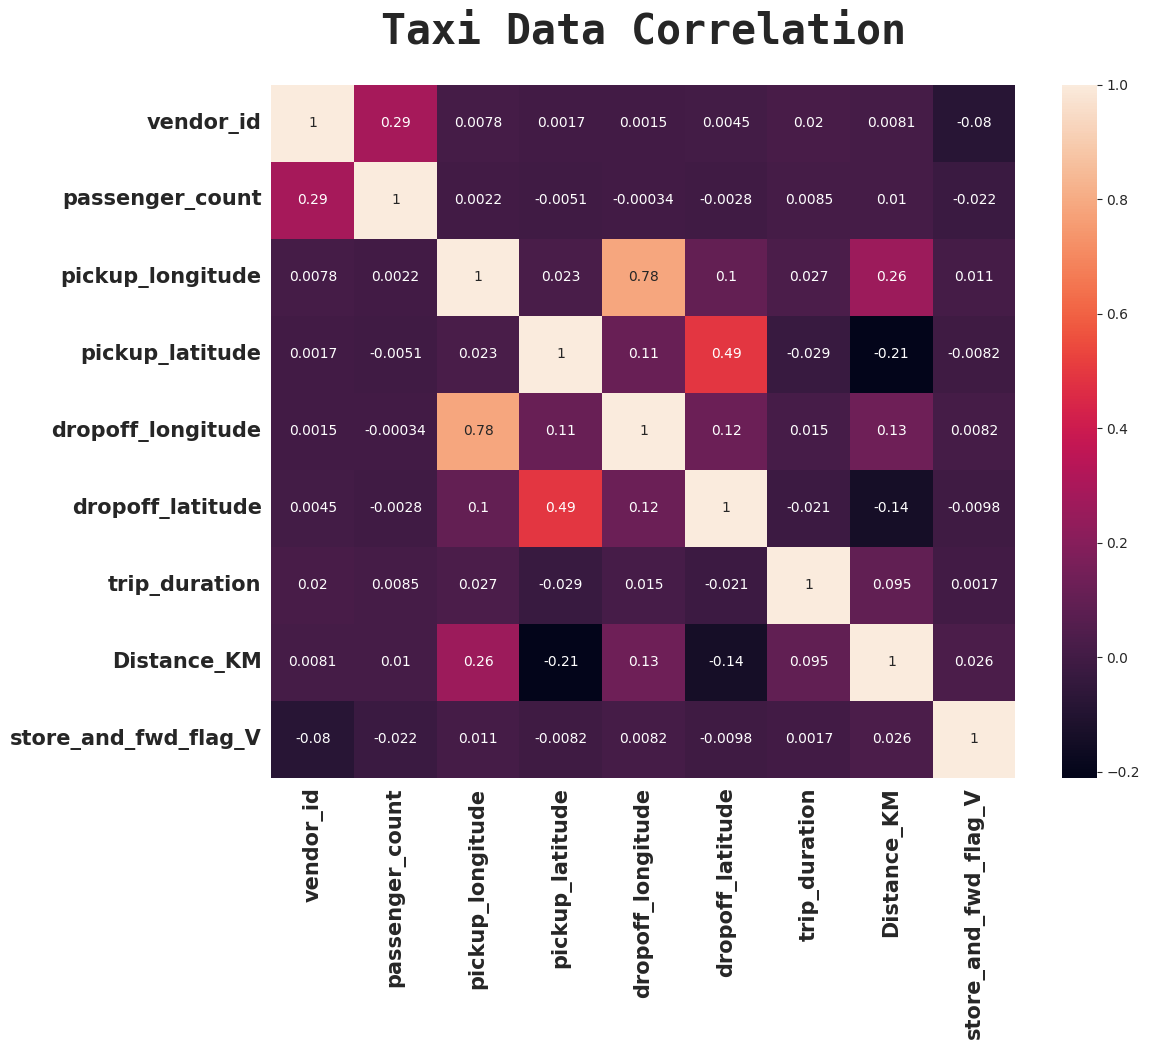

In [561]:
#check for correlation between numeric columns
numeric_columns = DF_file.select_dtypes(include=['float64', 'int64']).columns
sns.set_style("whitegrid") # set the seaborn style
plt.figure(figsize=(12, 9)) # figure the size
sns.heatmap(DF_file[numeric_columns].corr(), annot=True) # create a heatmap
plt.title("Taxi Data Correlation", weight="bold", fontsize=30, fontname="monospace", pad=30) # title
plt.xticks(weight="bold", fontsize=15) # x-ticks
plt.yticks(weight="bold", fontsize=15); # y-ticks

In [562]:
# Let's see the correlation clearly for the trip duration
(DF_file[numeric_columns].corr()["trip_duration"] # transform it into data corr
      .sort_values(ascending=False) # sort the values
      .to_frame() # change it into data frame
      .T) # transpose

,trip_duration,Distance_KM,pickup_longitude,vendor_id,dropoff_longitude,passenger_count,store_and_fwd_flag_V,dropoff_latitude,pickup_latitude
trip_duration,1.0,0.094791,0.026547,0.020296,0.014682,0.008452,0.001725,-0.020673,-0.029201


**Feature engineering**

convert row data to valid formats for later application

First, change datatime formats to seperate columns

In [563]:
object_columns =DF_file.select_dtypes(include=['object']).columns
for col in object_columns:
    print(f'{col}: {DF_file[col].nunique()}')
    print(f'{col}: {DF_file[col].unique()}', end='\n\n')

pickup_datetime: 1380222
pickup_datetime: ['2016-03-14 17:24:55' '2016-06-12 00:43:35' '2016-01-19 11:35:24' ...
 '2016-01-10 07:35:15' '2016-04-22 06:57:41' '2016-01-05 15:56:26']

dropoff_datetime: 1380377
dropoff_datetime: ['2016-03-14 17:32:30' '2016-06-12 00:54:38' '2016-01-19 12:10:48' ...
 '2016-04-22 07:10:25' '2016-01-05 16:02:39' '2016-04-05 14:47:43']



In [564]:
# Extract start time and end time
DF_file['pickup_hour'] = pd.to_datetime(DF_file['pickup_datetime']).dt.hour
DF_file['pickup_day'] = pd.to_datetime(DF_file['pickup_datetime']).dt.day
DF_file['pickup_month'] = pd.to_datetime(DF_file['pickup_datetime']).dt.month
DF_file.drop('pickup_datetime', axis=1, inplace=True)

DF_file['dropoff_hour'] = pd.to_datetime(DF_file['dropoff_datetime']).dt.hour
DF_file['dropoff_day'] = pd.to_datetime(DF_file['dropoff_datetime']).dt.day
DF_file['dropoff_month'] = pd.to_datetime(DF_file['dropoff_datetime']).dt.month
DF_file.drop('dropoff_datetime', axis=1, inplace=True)


Drop unnecessary columns

In [565]:
'''
DF_file.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)
DF_file.head()
'''

"\nDF_file.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)\nDF_file.head()\n"

after droping unnecessary columns
checking correlation for relevant attribnutes

In [566]:
# Let's see the correlation clearly for the trip duration
(DF_file[numeric_columns].corr()["trip_duration"] # transform it into data corr
      .sort_values(ascending=False) # sort the values
      .to_frame() # change it into data frame
      .T) # transpose

,trip_duration,Distance_KM,pickup_longitude,vendor_id,dropoff_longitude,passenger_count,store_and_fwd_flag_V,dropoff_latitude,pickup_latitude
trip_duration,1.0,0.094791,0.026547,0.020296,0.014682,0.008452,0.001725,-0.020673,-0.029201


In [567]:
#visualization and handling errors/outliars

In [568]:

DF_file['passenger_count'].value_counts()

,count
passenger_count,
1,1033539
2,210315
5,78088
3,59895
6,48333
4,28402
0,60
7,3
9,1


drop rows with no passenger count attribute

In [569]:
DF_file = DF_file[DF_file['passenger_count'] != 0]

In [570]:
DF_file['store_and_fwd_flag_V'].value_counts()

,count
store_and_fwd_flag_V,
0,1450535
1,8042


In [571]:
DF_file['trip_duration'].value_counts()

,count
trip_duration,
368,1624
408,1584
348,1582
367,1581
358,1577
...,...
85002,1
81146,1
84575,1


In [572]:
DF_file[DF_file['trip_duration']<=0]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,Distance_KM,store_and_fwd_flag_V,pickup_hour,pickup_day,pickup_month,dropoff_hour,dropoff_day,dropoff_month


In [573]:
DF_file['Distance_KM'].value_counts()

,count
Distance_KM,
0.000000,5888
0.000424,101
0.000424,52
0.000424,48
0.000848,37
...,...
1.795028,1
8.261528,1
1.388063,1


In [574]:
DF_file[DF_file['Distance_KM']<=0]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,Distance_KM,store_and_fwd_flag_V,pickup_hour,pickup_day,pickup_month,dropoff_hour,dropoff_day,dropoff_month
246,2,1,-73.981819,40.768963,-73.981819,40.768963,227,0.0,0,18,29,2,18,29,2
291,2,2,-73.959068,40.775661,-73.959068,40.775661,1109,0.0,0,18,10,5,18,10,5
407,2,6,-73.808487,40.687336,-73.808487,40.687336,947,0.0,0,23,16,5,23,16,5
702,1,1,-73.786720,40.647041,-73.786720,40.647041,580,0.0,0,19,25,1,19,25,1
1620,1,1,-74.209854,40.816853,-74.209854,40.816853,27,0.0,0,22,27,1,22,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456399,2,1,-73.978859,40.756721,-73.978859,40.756721,1284,0.0,0,8,17,2,9,17,2
1456627,2,1,-73.963554,40.768517,-73.963554,40.768517,127,0.0,0,22,6,2,22,6,2
1456989,2,1,-73.984848,40.728222,-73.984848,40.728222,566,0.0,0,7,12,3,7,12,3
1457114,2,1,-73.965981,40.770988,-73.965981,40.770988,632,0.0,0,20,9,4,20,9,4


In [575]:
DF_file = DF_file[DF_file['Distance_KM'] != 0]
DF_file.shape

(1452689, 15)

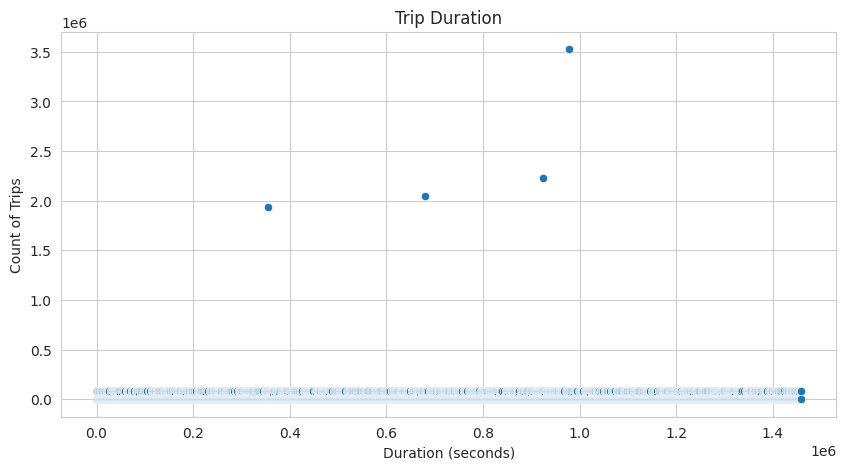

In [576]:
# Scatter for trip duration
plt.figure(figsize=(10, 5))
sns.scatterplot(data=DF_file['trip_duration'])
plt.title("Trip Duration")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count of Trips")
plt.show()
# results shows a signficant outliars that hinders the analysis which results in extremely high durations skew the visualization.


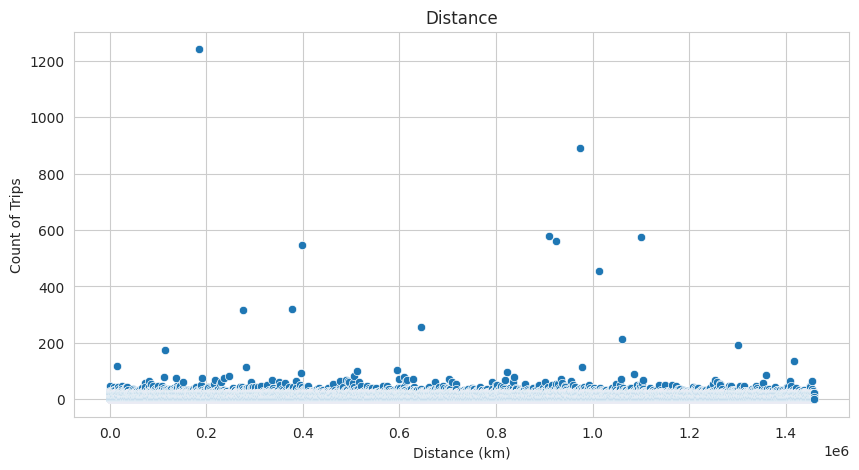

In [577]:
# Scatter for Distance
plt.figure(figsize=(10, 5))
sns.scatterplot(data=DF_file['Distance_KM'])
plt.title("Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Count of Trips")
plt.show()
# similar is shown for the distance

Cap duration: 3442.0 in seconds 
Cap distance: 24.795344966629102 in km


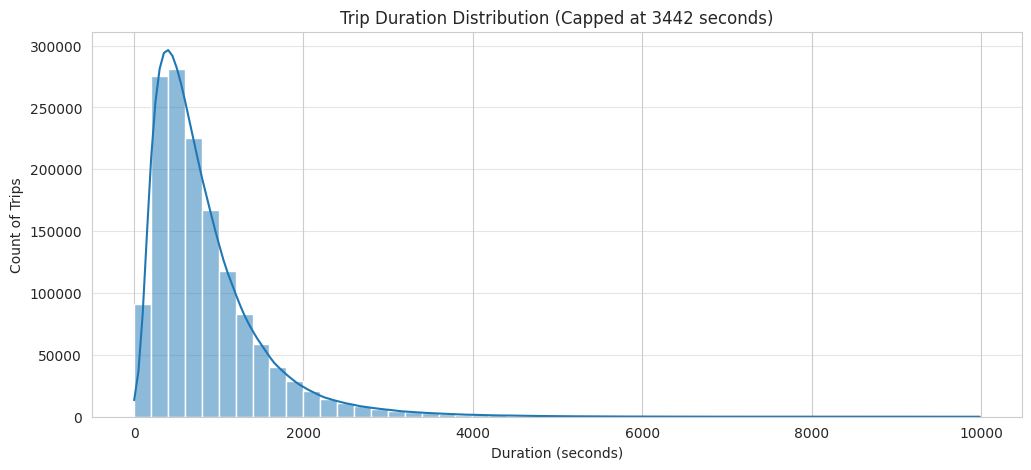

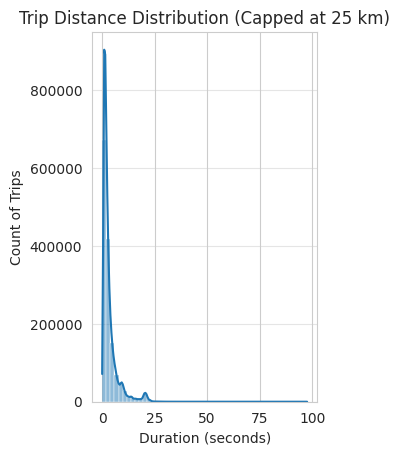

In [578]:
#avoid the outliars in both trip time and distance
# we select all datra with values below the 97.5th percentile for duration and 99.9th for distance


cap_duration = DF_file['trip_duration'].quantile(0.99)
cap_distance = DF_file['Distance_KM'].quantile(0.999)
print (f'Cap duration: {cap_duration} in seconds \nCap distance: {cap_distance} in km')
'''
# Filter the data to remove extreme outliers for better visualization
df_filtered = DF_file[DF_file['trip_duration'] <= cap_duration]
# Filter the data to remove extreme outliers for better visualization
df_filtered = df_filtered[df_filtered['Distance_KM'] <= cap_distance]

print(df_filtered.shape)
'''


df_filtered = DF_file[DF_file['Distance_KM'] < 100]
df_filtered = df_filtered[df_filtered['trip_duration'] < 10000]



# Use a Histogram to visualize the distribution for trip duration
plt.figure(figsize=(12, 5))
plt.subplot(1, 1, 1)
sns.histplot(data=df_filtered, x='trip_duration', bins=50, kde=True)
plt.title(f"Trip Duration Distribution (Capped at {cap_duration:.0f} seconds)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count of Trips")
plt.grid(axis='y', alpha=0.5)
plt.show()

'''
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_filtered['trip_duration'], bins=50, kde=True)
plt.title("Distribution of Trip Duration")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
'''

# Use a Histogram to visualize the distribution for trip ditsnace
plt.subplot(1, 2, 2)
sns.histplot(data=df_filtered, x='Distance_KM', bins=50, kde=True)
plt.title(f"Trip Distance Distribution (Capped at {cap_distance:.0f} km)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count of Trips")
plt.grid(axis='y', alpha=0.5)
plt.show()

In [579]:
#df_filtered

In [580]:
# Scatter for trip duration
'''
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_filtered['trip_duration'])
plt.title("Trip Duration")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count of Trips")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_filtered['Distance_KM'])
plt.title("Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Count of Trips")
plt.show()
'''

'\nplt.figure(figsize=(12, 5))\nplt.subplot(1, 2, 1)\nsns.scatterplot(data=df_filtered[\'trip_duration\'])\nplt.title("Trip Duration")\nplt.xlabel("Duration (seconds)")\nplt.ylabel("Count of Trips")\n\nplt.subplot(1, 2, 2)\nsns.scatterplot(data=df_filtered[\'Distance_KM\'])\nplt.title("Distance")\nplt.xlabel("Distance (km)")\nplt.ylabel("Count of Trips")\nplt.show()\n'

Remove data outside NY city (Outliers)

In [581]:

# Define NYC Bounding Box and Filter Outliers
NYC_BOUNDS = {
    'min_lat': 40.5, 'max_lat': 40.9,
    'min_lon': -74.25, 'max_lon': -73.70
}
# filter points only inside NY city
df_filtered = df_filtered[
(df_filtered['pickup_latitude'] >= NYC_BOUNDS['min_lat']) &
(df_filtered['pickup_latitude'] <= NYC_BOUNDS['max_lat']) &
(df_filtered['pickup_longitude'] >= NYC_BOUNDS['min_lon']) &
(df_filtered['pickup_longitude'] <= NYC_BOUNDS['max_lon'])
]



Only for viosualization

In [582]:
'''remove to run
# update GeoDF
geometry = [Point(xy) for xy in zip(DF_file['pickup_longitude'], DF_file['pickup_latitude'])]
gdf = gpd.GeoDataFrame(DF_file.copy(), geometry=geometry, crs='EPSG:4326')


# convert to local projection
gdf_web_mercator = gdf.to_crs(epsg=3857)
# Plot the points .
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf_web_mercator.plot(
    ax=ax,
    marker='o',
    color='red',
    markersize=5,
    alpha=0.3,
    label='Pickup Location'
)

# Add the basemap and retrieves the appropriate map tiles.
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(f"Taxi Pickup Locations in NYC (N={len(DF_file)})")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
plt.legend()
plt.tight_layout()
plt.show()
'''

'remove to run\n# update GeoDF\ngeometry = [Point(xy) for xy in zip(DF_file[\'pickup_longitude\'], DF_file[\'pickup_latitude\'])]\ngdf = gpd.GeoDataFrame(DF_file.copy(), geometry=geometry, crs=\'EPSG:4326\')\n\n\n# convert to local projection\ngdf_web_mercator = gdf.to_crs(epsg=3857)\n# Plot the points .\nfig, ax = plt.subplots(1, 1, figsize=(12, 12))\ngdf_web_mercator.plot(\n    ax=ax,\n    marker=\'o\',\n    color=\'red\',\n    markersize=5,\n    alpha=0.3,\n    label=\'Pickup Location\'\n)\n\n# Add the basemap and retrieves the appropriate map tiles.\nctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)\n\nax.set_title(f"Taxi Pickup Locations in NYC (N={len(DF_file)})")\nax.set_xlabel("Easting")\nax.set_ylabel("Northing")\nplt.legend()\nplt.tight_layout()\nplt.show()\n'

In [583]:
#remove the unrequired attributres
'''
df_filtered.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)
df_filtered.head(2)
'''

"\ndf_filtered.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)\ndf_filtered.head(2)\n"

In [584]:
#removed rows
current_rows, current_cols = df_filtered.shape
print(f'Removed rows =  {init_rows- current_rows}\nwhich is about {round((init_rows- current_rows)/init_rows*100,2)}%')

Removed rows =  8281
which is about 0.57%


Normalizing data

In [585]:

scaler = minmax_scale(df_filtered, axis=0)
df_filtered = pd.DataFrame(scaler, columns=df_filtered.columns)
df_filtered.tail()


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,Distance_KM,store_and_fwd_flag_V,pickup_hour,pickup_day,pickup_month,dropoff_hour,dropoff_day,dropoff_month
1450358,1.0,0.428571,0.477670,0.608541,0.379870,0.387807,0.077832,0.012550,0.0,0.565217,0.233333,0.6,0.565217,0.233333,0.5
1450359,0.0,0.000000,0.442078,0.613267,0.391905,0.434410,0.065511,0.061991,0.0,0.304348,0.300000,0.0,0.304348,0.300000,0.0
1450360,1.0,0.000000,0.521475,0.667753,0.375236,0.360694,0.076430,0.080177,0.0,0.260870,0.700000,0.6,0.304348,0.700000,0.5
1450361,0.0,0.000000,0.477902,0.617546,0.389740,0.401808,0.037263,0.011192,0.0,0.652174,0.133333,0.0,0.695652,0.133333,0.0
1450362,0.0,0.000000,0.482726,0.700698,0.390627,0.429481,0.019734,0.011617,0.0,0.608696,0.133333,0.6,0.608696,0.133333,0.5


# **Traing Data with linear regression **

In [586]:
x = df_filtered.drop('trip_duration', axis=1)
y = df_filtered['trip_duration']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1160290, 14), (290073, 14), (1160290,), (290073,))

In [587]:
pipline = {
    'Linear Regression': LinearRegression()
}
for name, model in pipline.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    r2_train = r2_score(y_train, model.predict(x_train))
    r2_test = r2_score(y_test, y_pred)
    # Extract coefficients (m)
    coefficients = model.coef_
    # Extract intercept (n)
    intercept = model.intercept_

    print(f'--- Model: {name} ---')
    print(f'MSE: {mse:.2f}')
    print(f'R2 train: {r2_train:.4f}')
    print(f'R2 test: {r2_test:.4f}')
    print(f'\nCoefficients (m):')
    for i, coeff in enumerate(coefficients):
        print(f'  {x_train.columns[i]}: {coeff:.4f}')
    print(f'Intercept (n): {intercept:.4f}')

    # Optional: Print the full equation
    equation = f"y = {intercept:.4f}"
    for i, coeff in enumerate(coefficients):
        equation += f" + ({coeff:.4f})*{x_train.columns[i]}"
    print(f'\nRegression Equation:\n{equation}')

--- Model: Linear Regression ---
MSE: 0.00
R2 train: 0.6277
R2 test: 0.6276

Coefficients (m):
  vendor_id: -0.0000
  passenger_count: 0.0018
  pickup_longitude: -0.0274
  pickup_latitude: 0.0391
  dropoff_longitude: -0.1882
  dropoff_latitude: -0.1529
  Distance_KM: 1.2453
  store_and_fwd_flag_V: 0.0050
  pickup_hour: -0.4817
  pickup_day: -14.6925
  pickup_month: -74.2528
  dropoff_hour: 0.4925
  dropoff_day: 14.6939
  dropoff_month: 89.1137
Intercept (n): 0.1469

Regression Equation:
y = 0.1469 + (-0.0000)*vendor_id + (0.0018)*passenger_count + (-0.0274)*pickup_longitude + (0.0391)*pickup_latitude + (-0.1882)*dropoff_longitude + (-0.1529)*dropoff_latitude + (1.2453)*Distance_KM + (0.0050)*store_and_fwd_flag_V + (-0.4817)*pickup_hour + (-14.6925)*pickup_day + (-74.2528)*pickup_month + (0.4925)*dropoff_hour + (14.6939)*dropoff_day + (89.1137)*dropoff_month


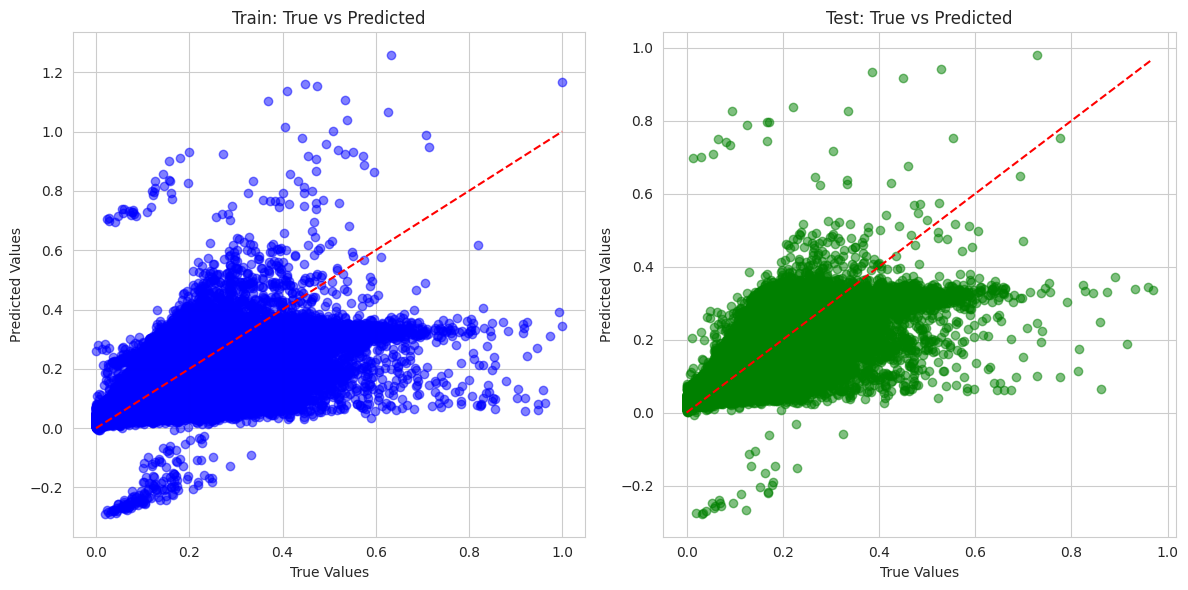

In [588]:
y_train_pred = pipline['Linear Regression'].predict(x_train)
y_test_pred = pipline['Linear Regression'].predict(x_test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
plt.title("Train: True vs Predicted")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Test: True vs Predicted")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

plt.tight_layout()
plt.show()